In [115]:
import tensorflow as tf 
import tensorflow_datasets as tfds 

get the Oxford Flowers 102 data.

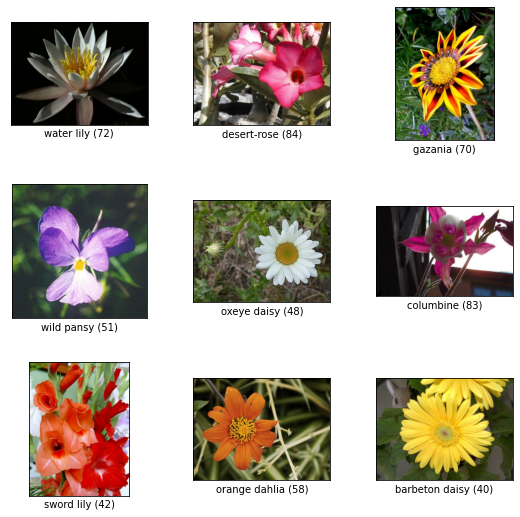

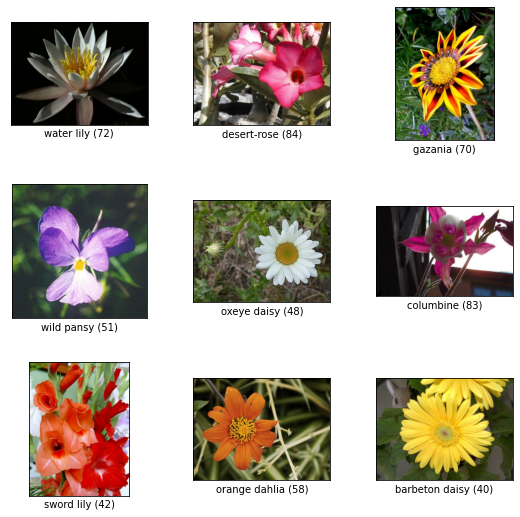

In [116]:
#get the Oxford 102 dataset. 

train_dataset, train_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True, split="train")
test_dataset, test_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True, split="test")


tfds.visualization.show_examples(train_dataset, train_info)

mapping function for preprocessing the dataset.

In [117]:
#map function to preprocess the dataset.
def process_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255. 
  image = tf.image.resize_with_pad(image, target_height=500, target_width=668)

  return image, image

preprocess the data.

In [118]:
BUFFER_SIZE = 512
BATCH_SIZE = 16

train_dataset = train_dataset.map(process_image)
test_dataset = test_dataset.map(process_image)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset = test_dataset.batch(BATCH_SIZE)


NUM_TRAIN_EXAMPLES = train_info.splits["train"].num_examples


Build the model.

In [119]:
def encoder(inputs):
  encoder = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
  encoder = tf.keras.layers.ZeroPadding2D((6,2))(encoder)
  encoder = tf.keras.layers.MaxPooling2D((2,2))(encoder)
  encoder = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(encoder)
  encoder = tf.keras.layers.MaxPooling2D((2,2))(encoder)
  encoder = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(encoder)
  encoder = tf.keras.layers.MaxPooling2D((2,2))(encoder)
  encoder = tf.keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(encoder)
  encoder = tf.keras.layers.MaxPooling2D((2,2))(encoder)
  encoder = tf.keras.layers.Conv2D(512, (3,3), activation="relu", padding="same")(encoder)
  encoder = tf.keras.layers.MaxPooling2D((2,2))(encoder)
  
  #this encoder output will be picked up by the bottleneck component.
  return encoder

#in this part, there is no more downsampling, just deepen the feature map (more filters) and add a visualization layer.
def bottle_neck(inputs):
  
  #this bottle neck output will continue the journey into the decoder.
  bottle_neck = tf.keras.layers.Conv2D(1024, (3,3), activation="relu", padding="same")(inputs)

  #this layer is just for getting a feature map to visualize the encoder output, hence a 3 filters (original images are RGB).
  encoder_visualization = tf.keras.layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(bottle_neck)

  return bottle_neck, encoder_visualization

#takes in the bottleneck, get the image back to its original size by upsampling and convolutions.
def decoder(inputs):
  #these conv layers do two things: 1) learn the filters that decode the encoder output back to original image, b) revert the filter numbers (depth)
  decoder = tf.keras.layers.Conv2D(512, (3,3), activation="relu", padding="same")(inputs)
  #upsample after each convolution to retrieve the original image dimensions.
  decoder = tf.keras.layers.UpSampling2D(size=(2,2))(decoder)
  decoder = tf.keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(decoder)
  decoder = tf.keras.layers.UpSampling2D(size= (2,2))(decoder)
  decoder = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(decoder)
  decoder = tf.keras.layers.UpSampling2D(size= (2,2))(decoder)
  decoder = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(decoder)
  decoder = tf.keras.layers.UpSampling2D(size= (2,2))(decoder)
  decoder = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(decoder)
  decoder = tf.keras.layers.UpSampling2D(size= (2,2))(decoder)
  decoder = tf.keras.layers.Cropping2D((6, 2))(decoder)

  #reason I'm returning 3 filters here is that the original images are RGB, they have 3 filters.
  decoder_output = tf.keras.layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(decoder)

  return decoder_output

In [120]:
def convolutional_autoencoder():
  inputs = tf.keras.layers.Input(shape=(500, 668, 3,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_viz = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)
  model = tf.keras.Model(inputs = inputs, outputs = decoder_output)
  encoder_model = tf.keras.Model(inputs = inputs, outputs = encoder_viz)

  return model, encoder_model

In [121]:
cnn_autoencoder, cnn_encoder = convolutional_autoencoder()
cnn_autoencoder.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 500, 668, 3)]     0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 500, 668, 32)      896       
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 512, 672, 32)      0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 256, 336, 32)      0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 256, 336, 64)      18496     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 128, 168, 64)      0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 128, 168, 128)     738

In [122]:
train_steps = NUM_TRAIN_EXAMPLES // BATCH_SIZE
valid_steps = test_info.splits["test"].num_examples // BATCH_SIZE

cnn_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss= "binary_crossentropy")

history = cnn_autoencoder.fit(train_dataset, steps_per_epoch=train_steps, validation_data = test_dataset, validation_steps = valid_steps, epochs=20)

Epoch 1/20
63/63 [==============================] - 239s 4s/step - loss: 0.6351 - val_loss: 0.4785
Epoch 2/20
63/63 [==============================] - 233s 4s/step - loss: 0.4701 - val_loss: 0.4497
Epoch 3/20
63/63 [==============================] - 223s 4s/step - loss: 0.4467 - val_loss: 0.4380
Epoch 4/20
63/63 [==============================] - 222s 4s/step - loss: 0.4368 - val_loss: 0.4374
Epoch 5/20
63/63 [==============================] - 222s 4s/step - loss: 0.4303 - val_loss: 0.4329
Epoch 6/20
63/63 [==============================] - 222s 4s/step - loss: 0.4260 - val_loss: 0.4290
Epoch 7/20
63/63 [==============================] - 223s 4s/step - loss: 0.4329 - val_loss: 0.4285
Epoch 8/20
63/63 [==============================] - 224s 4s/step - loss: 0.4249 - val_loss: 0.4269
Epoch 9/20
63/63 [==============================] - 225s 4s/step - loss: 0.4203 - val_loss: 0.4251
Epoch 10/20
63/63 [==============================] - 223s 4s/step - loss: 0.4250 - val_loss: 0.4275
Epoch 11/

In [131]:
def display_one_row(disp_images, offset, shape=(500, 668,3)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(500,668,3))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(500,668,3))

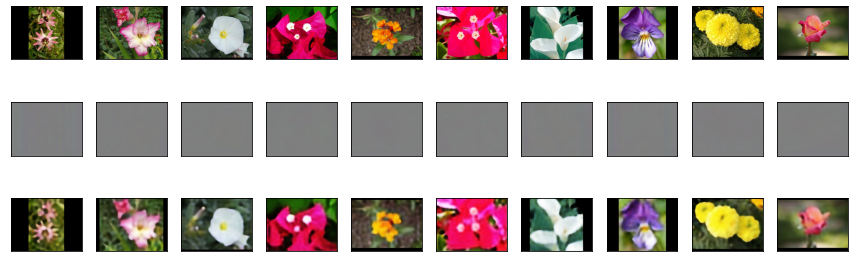

In [136]:
import numpy as np
import matplotlib.pyplot as plt
cnn_autoencoder.save("model.h5")


# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 500, 668, 3))

# get the encoder ouput
encoded = cnn_encoder.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = cnn_autoencoder.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(16,21,3))

cnn_autoencoder.save("model.h5")